# Song Recommender with Lyrics

## Setup and Installation

In [ ]:
# Install required packages
!pip install opendatasets pandas numpy scikit-learn sentence-transformers gensim matplotlib tqdm

# Install Tinker and Tinker Cookbook from GitHub
!pip install tinker datasets
!pip install git+https://github.com/thinking-machines-lab/tinker-cookbook.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 4.8 MB/s eta 0:00:00
  Cloning https://github.com/thinking-machines-lab/tinker-cookbook.git to /tmp/pip-req-build-vxvz2dno
  Running command git clone --filter=blob:none --quiet https://github.com/thinking-machines-lab/tinker-cookbook.git /tmp/pip-req-build-vxvz2dno
  Resolved https://github.com/thinking-machines-lab/tinker-cookbook.git to commit 989f84926245b227634797b8eac46abe232f9c24
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 82.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with

In [ ]:
import pandas as pd
import numpy as np
import os
import json
import re
from collections import defaultdict
from difflib import SequenceMatcher
from dataclasses import dataclass
from typing import List, Set, Dict, Tuple

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sentence_transformers import SentenceTransformer
import gensim.downloader as api
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

## 1. Data Cleaning and Preparation

In [ ]:
try:
    import opendatasets as od
    dataset_url = "https://www.kaggle.com/datasets/mateibejan/multilingual-lyrics-for-genre-classification"
    print("Downloading dataset from Kaggle...")
    od.download(dataset_url)
    data_dir = "./multilingual-lyrics-for-genre-classification"
except ImportError:
    print("opendatasets not installed. Please place train.csv and test.csv in current directory.")
    data_dir = "."

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aadhiaravind123
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mateibejan/multilingual-lyrics-for-genre-classification


100%|██████████| 103M/103M [00:00<00:00, 1.72GB/s]

In [ ]:
# Load and combine datasets
try:
    df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
    df_test = pd.read_csv(os.path.join(data_dir, 'test.csv'))
    df = pd.concat([df_train, df_test], ignore_index=True)
except FileNotFoundError:
    df = pd.read_csv('train.csv')

# Filter to English songs
df = df[df["Language"] == "en"]

# Rename columns
df = df.rename(columns={'Song': 'title', 'Artist': 'artist', 'Genre': 'genre', 'Lyrics': 'lyrics'})
df = df[['title', 'artist', 'genre', 'lyrics']]

print(f"Total English songs: {len(df)}")
print(f"Genres: {df['genre'].nunique()}")
print(df['genre'].value_counts())

Total English songs: 250197
Genres: 10
genre
Rock          107145
Pop            86298
Metal          19133
Jazz           13314
Folk            8169
Indie           7240
R&B             2765
Hip-Hop         2238
Electronic      2005
Country         1890
Name: count, dtype: int64


In [ ]:
# Clean lyrics
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = text.replace('\n', ' ').replace('\r', ' ')
    text = ' '.join(text.split())
    return text

df['clean_lyrics'] = df['lyrics'].apply(clean_text)

In [ ]:
# Stratified sampling: 1000 songs per genre
df_sample = df.groupby('genre', group_keys=False).apply(
    lambda x: x.sample(min(len(x), 1000), random_state=42)
).reset_index(drop=True)

print(f"\nSampled dataset: {len(df_sample)} songs")
print(df_sample['genre'].value_counts())


Sampled dataset: 10000 songs
genre
Country       1000
Electronic    1000
Folk          1000
Hip-Hop       1000
Indie         1000
Jazz          1000
Metal         1000
Pop           1000
R&B           1000
Rock          1000
Name: count, dtype: int64


## 2. Baseline Models: Embeddings

### Baseline 1: TF-IDF

In [ ]:
print("Building TF-IDF vectors...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df_sample['clean_lyrics'])

Building TF-IDF vectors...


### Baseline 2: Word2Vec

In [ ]:
# Train Word2Vec on our corpus
sentences = [text.split() for text in df_sample['clean_lyrics']]
w2v_model = Word2Vec(sentences=sentences, vector_size=200, window=5, min_count=2, workers=1, seed=42 epochs=10)

In [ ]:
# Create song embeddings by averaging word vectors
def get_w2v_embedding(text, model):
    words = text.split()
    vectors = [model.wv[word] for word in words if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

word2vec_embeddings = np.array([
    get_w2v_embedding(text, w2v_model)
    for text in tqdm(df_sample['clean_lyrics'], desc="Word2Vec")
])

Word2Vec: 100%|██████████| 10000/10000 [00:04<00:00, 2351.26it/s]


### Baseline 3: SBERT

In [ ]:
print("Loading SBERT model...")
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

print("Encoding lyrics with SBERT...")
sbert_embeddings = sbert_model.encode(
    df_sample['clean_lyrics'].tolist(),
    show_progress_bar=True,
    batch_size=32
)
print(f"✅ SBERT embeddings shape: {sbert_embeddings.shape}")

Loading SBERT model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Encoding lyrics with SBERT...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

✅ SBERT embeddings shape: (10000, 384)


In [ ]:

from sklearn.metrics.pairwise import linear_kernel

def evaluate_genre_based(df, tfidf_mat, word2vec_mat, sbert_mat, k_list=[5, 10], sample_size=300):
    """
    Evaluate models using genre as ground truth.
    Songs with same genre are considered similar.
    """
    print(f"Sampling {sample_size} query songs for evaluation...")

    # Sample queries
    np.random.seed(42)
    query_indices = np.random.choice(len(df), min(sample_size, len(df)), replace=False)

    # Initialize results
    results = {
        'TF-IDF': {k: {'precision': [], 'recall': [], 'ndcg': [], 'mrr': [], 'hit': []} for k in k_list},
        'Word2Vec': {k: {'precision': [], 'recall': [], 'ndcg': [], 'mrr': [], 'hit': []} for k in k_list},
        'SBERT': {k: {'precision': [], 'recall': [], 'ndcg': [], 'mrr': [], 'hit': []} for k in k_list}
    }

    max_k = max(k_list)

    # Evaluate each query
    for idx in tqdm(query_indices, desc="Evaluating Genre-Based"):
        query_genre = df.iloc[idx]['genre']

        # Get all songs with same genre (ground truth)
        relevant_indices = set(df[df['genre'] == query_genre].index.tolist())
        relevant_indices.discard(idx)  # Remove query itself

        if len(relevant_indices) == 0:
            continue

        # Get scores for each model
        # TF-IDF
        tfidf_scores = linear_kernel(tfidf_mat[idx], tfidf_mat).flatten()
        tfidf_scores[idx] = -np.inf

        # Word2Vec
        word2vec_scores = cosine_similarity(word2vec_mat[idx].reshape(1, -1), word2vec_mat).flatten()
        word2vec_scores[idx] = -np.inf

        # SBERT
        sbert_scores = cosine_similarity(sbert_mat[idx].reshape(1, -1), sbert_mat).flatten()
        sbert_scores[idx] = -np.inf

        # Process each model
        for name, scores in [('TF-IDF', tfidf_scores), ('Word2Vec', word2vec_scores), ('SBERT', sbert_scores)]:
            # Get top indices
            top_indices = np.argpartition(scores, -max_k)[-max_k:]
            top_indices = top_indices[np.argsort(scores[top_indices])[::-1]]

            # Calculate metrics for each k
            for k in k_list:
                current_k = top_indices[:k]

                # Precision@K
                hits = len(set(current_k) & relevant_indices)
                precision = hits / k
                results[name][k]['precision'].append(precision)

                # Recall@K
                recall = hits / len(relevant_indices)
                results[name][k]['recall'].append(recall)

                # Hit@K (binary: did we find at least one?)
                hit = 1.0 if hits > 0 else 0.0
                results[name][k]['hit'].append(hit)

                # MRR (Mean Reciprocal Rank)
                mrr = 0.0
                for rank, rec_idx in enumerate(current_k):
                    if rec_idx in relevant_indices:
                        mrr = 1.0 / (rank + 1)
                        break
                results[name][k]['mrr'].append(mrr)

                # NDCG
                relevance = np.array([1.0 if rec_idx in relevant_indices else 0.0 for rec_idx in current_k])
                dcg = np.sum(relevance / np.log2(np.arange(2, k + 2)))
                ideal_relevance = np.sort(relevance)[::-1]
                idcg = np.sum(ideal_relevance / np.log2(np.arange(2, k + 2)))
                ndcg = dcg / idcg if idcg > 0 else 0.0
                results[name][k]['ndcg'].append(ndcg)

    # Aggregate results
    final_rows = []
    for model in ['TF-IDF', 'Word2Vec', 'SBERT']:
        for k in k_list:
            final_rows.append({
                'Model': model,
                'K': k,
                'Precision@K': np.mean(results[model][k]['precision']),
                'Recall@K': np.mean(results[model][k]['recall']),
                'NDCG@K': np.mean(results[model][k]['ndcg']),
                'MRR@K': np.mean(results[model][k]['mrr']),
                'Hit@K': np.mean(results[model][k]['hit'])
            })

    return pd.DataFrame(final_rows)

# Run genre-based evaluation
genre_results = evaluate_genre_based(
    df_sample,
    tfidf_matrix,
    word2vec_embeddings,
    sbert_embeddings,
    k_list=[5, 10],
    sample_size=10000
)

print("\n" + "="*80)
print("📊 GENRE-BASED RESULTS")
print("="*80)
print(genre_results.to_string(index=False))

# Save results
genre_results.to_csv('genre_based_results.csv', index=False)
print("\n✅ Saved to 'genre_based_results.csv'")

# Summary
print("\n" + "="*80)
print("🎯 GENRE EVALUATION SUMMARY")
print("="*80)
print("\nKey Findings:")
print(f"  • Best model: {genre_results.loc[genre_results['K']==10, ['Model', 'Precision@K']].nlargest(1, 'Precision@K')['Model'].values[0]}")
print(f"  • Precision@10 range: {genre_results[genre_results['K']==10]['Precision@K'].min():.1%} - {genre_results[genre_results['K']==10]['Precision@K'].max():.1%}")
print(f"  • Hit@10 range: {genre_results[genre_results['K']==10]['Hit@K'].min():.1%} - {genre_results[genre_results['K']==10]['Hit@K'].max():.1%}")
print("\n✅ Baselines perform well on genre-based evaluation")
print("➡️  Next: Test on realistic playlist-based evaluation...\n")

Sampling 10000 query songs for evaluation...


Evaluating Genre-Based: 100%|██████████| 10000/10000 [05:42<00:00, 29.19it/s]



📊 GENRE-BASED RESULTS
   Model  K  Precision@K  Recall@K   NDCG@K    MRR@K  Hit@K
  TF-IDF  5      0.18286  0.000915 0.383075 0.329600 0.5544
  TF-IDF 10      0.17377  0.001739 0.441932 0.355718 0.7496
Word2Vec  5      0.22034  0.001103 0.410930 0.362572 0.5676
Word2Vec 10      0.20868  0.002089 0.461910 0.385470 0.7390
   SBERT  5      0.24506  0.001227 0.450104 0.400443 0.6148
   SBERT 10      0.23145  0.002317 0.497607 0.422348 0.7780

✅ Saved to 'genre_based_results.csv'

🎯 GENRE EVALUATION SUMMARY

Key Findings:
  • Best model: SBERT
  • Precision@10 range: 17.4% - 23.1%
  • Hit@10 range: 73.9% - 77.8%

✅ Baselines perform well on genre-based evaluation
➡️  Next: Test on realistic playlist-based evaluation...



## 3. Playlist-Based Ground Truth

In [ ]:
!pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 35.0 MB/s eta 0:00:00


In [ ]:
from dataclasses import dataclass
from typing import List, Dict, Set, Tuple
from collections import defaultdict
import pandas as pd
import numpy as np
import re
from difflib import SequenceMatcher
from tqdm import tqdm

@dataclass
class ManualSongEntry:
    title: str
    artist: str
    playlist: str

class ManualGroundTruth:
    def __init__(self, csv_path: str):
        self.entries: List[ManualSongEntry] = []
        self.playlists: Dict[str, List[ManualSongEntry]] = defaultdict(list)
        self._load_csv(csv_path)

    def _load_csv(self, path: str):
        df = pd.read_csv(path)
        for _, row in df.iterrows():
            entry = ManualSongEntry(
                title=str(row['title']),
                artist=str(row['artist']),
                playlist=str(row['playlist'])
            )
            self.entries.append(entry)
            self.playlists[entry.playlist].append(entry)

    def match_to_dataset(self, df: pd.DataFrame, min_score: float = 0.65):
        """Match playlist entries to dataset indices (OPTIMIZED)."""
        from collections import defaultdict

        self.matches: List[Tuple[ManualSongEntry, int, float]] = []
        self.index_to_playlists: Dict[int, Set[str]] = defaultdict(set)

        def normalize(text):
            text = str(text).lower()
            text = re.sub(r'[^a-z0-9\s]', '', text)
            text = re.sub(r'\s+', ' ', text).strip()
            text = re.sub(r'\s*\(feat[^)]*\)', '', text)
            text = re.sub(r'\s*\(ft[^)]*\)', '', text)
            return text

        print("Pre-normalizing dataset...")
        df['norm_title'] = df['title'].apply(normalize)
        df['norm_artist'] = df['artist'].apply(normalize)

        print("Building search index...")
        dataset_by_letter = defaultdict(list)
        for idx, row in df.iterrows():
            first_letter = row['norm_title'][0] if row['norm_title'] else 'z'
            dataset_by_letter[first_letter].append((idx, row))

        try:
            from rapidfuzz import fuzz
            use_rapidfuzz = True
            print("Using rapidfuzz...")
        except ImportError:
            use_rapidfuzz = False
            print("Using SequenceMatcher...")

        print("Matching...")
        for entry in tqdm(self.entries, desc="Matching"):
            norm_title = normalize(entry.title)
            norm_artist = normalize(entry.artist.split(';')[0])

            exact_matches = df[
                (df['norm_title'] == norm_title) &
                (df['norm_artist'] == norm_artist)
            ]

            if len(exact_matches) > 0:
                idx = exact_matches.index[0]
                self.matches.append((entry, idx, 1.0))
                self.index_to_playlists[idx].add(entry.playlist)
                continue

            first_letter = norm_title[0] if norm_title else 'z'
            candidates = dataset_by_letter.get(first_letter, [])

            best_score = 0.0
            best_idx = -1

            for idx, row in candidates:
                if use_rapidfuzz:
                    title_score = fuzz.ratio(norm_title, row['norm_title']) / 100
                    artist_score = fuzz.ratio(norm_artist, row['norm_artist']) / 100
                else:
                    title_score = SequenceMatcher(None, norm_title, row['norm_title']).ratio()
                    artist_score = SequenceMatcher(None, norm_artist, row['norm_artist']).ratio()

                combined_score = (title_score + artist_score) / 2

                if combined_score > best_score:
                    best_score = combined_score
                    best_idx = idx

            if best_score >= min_score:
                self.matches.append((entry, best_idx, best_score))
                self.index_to_playlists[best_idx].add(entry.playlist)

        print("Building co-occurrence...")
        self.cooccurrence: Dict[int, Set[int]] = defaultdict(set)

        for playlist_name, entries in self.playlists.items():
            matched_indices = [
                idx for entry, idx, score in self.matches
                if entry.playlist == playlist_name
            ]

            for i in matched_indices:
                for j in matched_indices:
                    if i != j:
                        self.cooccurrence[i].add(j)

        return self

    def get_query_songs(self) -> List[int]:
        return [idx for idx, neighbors in self.cooccurrence.items() if len(neighbors) > 0]

    def get_relevant_songs(self, query_idx: int) -> Set[int]:
        return self.cooccurrence.get(query_idx, set())

    def summary(self) -> str:
        n_playlists = len(self.playlists)
        n_entries = len(self.entries)
        n_matches = len(self.matches)
        n_queries = len(self.get_query_songs())

        avg_neighbors = np.mean([len(v) for v in self.cooccurrence.values()]) if self.cooccurrence else 0

        return f"""
Ground Truth Summary:
  Playlists: {n_playlists}
  Playlist entries: {n_entries}
  Matched to dataset: {n_matches} ({100*n_matches/n_entries:.1f}%)
  Query songs (with neighbors): {n_queries}
  Avg neighbors per query: {avg_neighbors:.1f}
"""

print("✅ ManualGroundTruth class defined")

✅ ManualGroundTruth class defined


###  Load Playlist Data

In [ ]:
gt = ManualGroundTruth('spotifyplaylist.csv')
gt.match_to_dataset(df_sample, min_score=0.65)
print(gt.summary())

Pre-normalizing dataset...
Building search index...
Using rapidfuzz...
Matching...


Matching: 100%|██████████| 850/850 [00:03<00:00, 224.60it/s]

Building co-occurrence...

Ground Truth Summary:
  Playlists: 17
  Playlist entries: 850
  Matched to dataset: 261 (30.7%)
  Query songs (with neighbors): 200
  Avg neighbors per query: 15.9



In [ ]:
from collections import defaultdict, Counter

In [ ]:
# Check quality of results
query_songs = gt.get_query_songs()

print("="*80)
print("🔍 GROUND TRUTH QUALITY CHECK")
print("="*80)

# Sample some queries
print(f"\n📊 Sample queries and their neighbors:")
for i, query_idx in enumerate(query_songs[:5], 1):
    neighbors = gt.cooccurrence[query_idx]
    query_song = df_sample.iloc[query_idx]

    print(f"\n{i}. Query: '{query_song['title']}' by {query_song['artist']}")
    print(f"   Genre: {query_song['genre']}")
    print(f"   Neighbors: {len(neighbors)}")
    print(f"   Appears in playlists: {list(gt.index_to_playlists[query_idx])}")

# Neighbor distribution
neighbor_counts = [len(gt.cooccurrence[q]) for q in query_songs]
print("\n" + "="*80)
print("📊 NEIGHBOR DISTRIBUTION")
print("="*80)
print(f"Min neighbors: {min(neighbor_counts)}")
print(f"Max neighbors: {max(neighbor_counts)}")
print(f"Median neighbors: {sorted(neighbor_counts)[len(neighbor_counts)//2]}")
print(f"Average neighbors: {sum(neighbor_counts)/len(neighbor_counts):.1f}")

print("\n📈 Distribution:")
from collections import Counter
dist = Counter(neighbor_counts)
for n in sorted(dist.keys())[:10]:
    print(f"  {n:2d} neighbors: {dist[n]:3d} queries")

🔍 GROUND TRUTH QUALITY CHECK

📊 Sample queries and their neighbors:

1. Query: 'they say it's wonderful' by sarah vaughan
   Genre: Jazz
   Neighbors: 34
   Appears in playlists: ['Just One of Those Things Radio', 'I Should Care Radio', 'Sweet Georgia Brown Radio']

2. Query: 'teach me tonight' by aretha franklin
   Genre: R&B
   Neighbors: 47
   Appears in playlists: ['Just One of Those Things Radio', 'I Should Care Radio', 'The Gentleman Is a Dope Radio', 'Sweet Georgia Brown Radio']

3. Query: 'do nothin' till you hear from me' by anthony wilson
   Genre: Jazz
   Neighbors: 21
   Appears in playlists: ['I Should Care Radio', 'Sweet Georgia Brown Radio']

4. Query: 'lullaby of birdland' by sarah vaughan
   Genre: Jazz
   Neighbors: 34
   Appears in playlists: ['Just One of Those Things Radio', 'I Should Care Radio', 'Sweet Georgia Brown Radio']

5. Query: 'let's misbehave' by eartha kitt
   Genre: Jazz
   Neighbors: 47
   Appears in playlists: ['Just One of Those Things Radio', 'I Sh

## 4. Evaluation Functions

In [ ]:
def compute_ranking_metrics(recommended: List[int], relevant: Set[int], k: int):
    """Compute precision, recall, NDCG, MRR, Hit@K."""
    top_k = recommended[:k]

    # Precision and Recall
    hits = [1 if idx in relevant else 0 for idx in top_k]
    precision = sum(hits) / k if k > 0 else 0
    recall = sum(hits) / len(relevant) if len(relevant) > 0 else 0

    # NDCG
    dcg = sum([(1 if top_k[i] in relevant else 0) / np.log2(i + 2) for i in range(k)])
    idcg = sum([1 / np.log2(i + 2) for i in range(min(k, len(relevant)))])
    ndcg = dcg / idcg if idcg > 0 else 0

    # MRR
    mrr = 0
    for i, idx in enumerate(top_k):
        if idx in relevant:
            mrr = 1 / (i + 1)
            break

    # Hit@K
    hit = 1 if sum(hits) > 0 else 0

    return {
        'precision': precision,
        'recall': recall,
        'ndcg': ndcg,
        'mrr': mrr,
        'hit': hit
    }

def evaluate_model(embeddings, query_indices, gt, k_values=[5, 10], model_name=""):
    """Evaluate a model with given embeddings."""
    results = []

    for k in k_values:
        metrics_sum = {'precision': 0, 'recall': 0, 'ndcg': 0, 'mrr': 0, 'hit': 0}

        for query_idx in tqdm(query_indices, desc=f"{model_name} K={k}"):
            # Compute similarities
            if hasattr(embeddings, 'toarray'):  # Sparse matrix (TF-IDF)
                query_vec = embeddings[query_idx]
                similarities = linear_kernel(query_vec, embeddings).flatten()
            else:  # Dense matrix
                query_vec = embeddings[query_idx].reshape(1, -1)
                similarities = cosine_similarity(query_vec, embeddings).flatten()

            # Set self-similarity to -inf
            similarities[query_idx] = -np.inf

            # Get top-K
            top_indices = np.argsort(similarities)[::-1][:k].tolist()

            # Get relevant songs
            relevant = gt.get_relevant_songs(query_idx)

            # Compute metrics
            metrics = compute_ranking_metrics(top_indices, relevant, k)
            for key in metrics_sum:
                metrics_sum[key] += metrics[key]

        # Average over queries
        n_queries = len(query_indices)
        results.append({
            'Model': model_name,
            'K': k,
            'Precision@K': metrics_sum['precision'] / n_queries,
            'Recall@K': metrics_sum['recall'] / n_queries,
            'NDCG@K': metrics_sum['ndcg'] / n_queries,
            'MRR@K': metrics_sum['mrr'] / n_queries,
            'Hit@K': metrics_sum['hit'] / n_queries
        })

    return results

## 5. Evaluate Baseline Models

In [ ]:
if len(query_songs) < 5:
    print("⚠️ Not enough matched songs! Add more to playlists.csv")
else:
    all_results = []

    # Evaluate TF-IDF
    results = evaluate_model(tfidf_matrix, query_songs, gt, k_values=[5, 10], model_name="TF-IDF")
    all_results.extend(results)

    # Evaluate Word2Vec
    results = evaluate_model(word2vec_embeddings, query_songs, gt, k_values=[5, 10], model_name="Word2Vec")
    all_results.extend(results)

    # Evaluate SBERT
    results = evaluate_model(sbert_embeddings, query_songs, gt, k_values=[5, 10], model_name="SBERT")
    all_results.extend(results)

    baseline_results_df = pd.DataFrame(all_results)
    print("\n📊 Baseline Results:")
    print(baseline_results_df.to_string(index=False))

SBERT K=10: 100%|██████████| 200/200 [00:02<00:00, 77.26it/s]


📊 Baseline Results:
   Model  K  Precision@K  Recall@K   NDCG@K    MRR@K  Hit@K
  TF-IDF  5        0.006  0.001803 0.004425 0.007667  0.030
  TF-IDF 10        0.005  0.003133 0.004305 0.010389  0.050
Word2Vec  5        0.007  0.002157 0.006844 0.015333  0.035
Word2Vec 10        0.005  0.003701 0.005670 0.017208  0.050
   SBERT  5        0.013  0.004432 0.013910 0.031833  0.060
   SBERT 10        0.010  0.006226 0.011782 0.035333  0.090


## 6.  Tinker SFT: Prepare Training Data

In [ ]:
def create_sft_dataset(df, gt, output_file='sft_data.jsonl', max_examples=1000, n_recommendations=5):
    """Create SFT dataset from playlist ground truth."""
    examples = []
    query_songs = gt.get_query_songs()

    np.random.seed(42)
    sampled_queries = np.random.choice(query_songs, min(max_examples, len(query_songs)), replace=False)

    for query_idx in tqdm(sampled_queries, desc="Creating SFT data"):
        # Get query song info
        query_row = df.iloc[query_idx]
        query_title = query_row['title']
        query_artist = query_row['artist']
        query_lyrics = query_row['clean_lyrics'][:1000]  # Truncate for efficiency

        # Get relevant songs (ground truth neighbors)
        relevant = list(gt.get_relevant_songs(query_idx))

        if len(relevant) < n_recommendations:
            continue

        # Sample recommendations
        sampled_relevant = np.random.choice(relevant, min(n_recommendations, len(relevant)), replace=False)

        # Build prompt
        prompt = f"""Recommend {n_recommendations} songs that are thematically and stylistically similar to the following song.

Title: {query_title}
Artist: {query_artist}
Lyrics:
{query_lyrics}

Please provide your recommendations in this format:
1. Song Title — Artist Name
2. Song Title — Artist Name
..."""

        # Build target (assistant response)
        recommendations = []
        for i, rec_idx in enumerate(sampled_relevant, 1):
            rec_row = df.iloc[rec_idx]
            recommendations.append(f"{i}. {rec_row['title']} — {rec_row['artist']}")

        target = "\n".join(recommendations)

        # Create JSONL entry
        example = {
            "messages": [
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": target}
            ]
        }
        examples.append(example)

    # Save to JSONL
    with open(output_file, 'w') as f:
        for example in examples:
            f.write(json.dumps(example) + '\n')

    print(f"\n✅ Created {len(examples)} SFT examples in {output_file}")
    return examples

In [ ]:
# Create SFT dataset
sft_examples = create_sft_dataset(df_sample, gt, output_file='song_sft_data.jsonl', max_examples=500)

# Show an example
if len(sft_examples) > 0:
    print("\n📝 Example training instance:")
    print("\nUser:")
    print(sft_examples[0]['messages'][0]['content'][:500])
    print("\n...\n\nAssistant:")
    print(sft_examples[0]['messages'][1]['content'])

Creating SFT data: 100%|██████████| 200/200 [00:00<00:00, 3960.50it/s]


✅ Created 200 SFT examples in song_sft_data.jsonl

📝 Example training instance:

User:
Recommend 5 songs that are thematically and stylistically similar to the following song.

Title: love hurts [*]
Artist: the everly brothers
Lyrics:
love hurts, love scars, love wounds and mars any heart not tough nor strong enough to take a lot of pain, take a lot of pain love is like a cloud, holds a lot of rain love hurts love hurts i'm young, i know, but even so i know a thing or two i've learned from you i've really learned a lot, really learned a lot love is like a stove, burns you when it'

...

Assistant:
1. if i can dream [alternate take 1] — elvis presley
2. i want to go home — fats domino
3. always on my mind [alternate take 2] — elvis presley
4. in my dreams — conway twitty
5. love is strange — everything but the girl


## 7. Tinker Fine-Tuning


In [ ]:

import os

os.environ['TINKER_API_KEY'] = "tml-ofiarv2QISpKXUasGbPE8mLSScmjODr0rssCVqToj17vixhQxaFa1pAWyTRMb1nGBAAAA"
TINKER_API_KEY = os.environ.get('TINKER_API_KEY')

# Check if key is set
if TINKER_API_KEY is None:
    print("⚠️  TINKER_API_KEY not set!")
    print("Please uncomment Option 1 above and add your key, or use Option 2/3.")
    print("\nGet your API key from: https://www.tinker.ai/")
else:
    print("Tinker API key loaded successfully")

Tinker API key loaded successfully


In [ ]:
# Import Tinker for fine-tuning
import tinker
from tinker_cookbook import renderers, model_info
from tinker_cookbook.tokenizer_utils import get_tokenizer
from tinker_cookbook.supervised.data import conversation_to_datum
from tinker_cookbook.supervised.common import compute_mean_nll
import datasets
import logging

logging.basicConfig(level=logging.INFO)

In [ ]:
# Training configuration
MODEL_NAME = "meta-llama/Llama-3.2-1B"
LORA_RANK = 32
LEARNING_RATE = 1e-4
BATCH_SIZE = 4
MAX_LENGTH = 4096
NUM_EPOCHS = 3

print(f"Training configuration:")
print(f"  Model: {MODEL_NAME}")
print(f"  LoRA rank: {LORA_RANK}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Max length: {MAX_LENGTH}")
print(f"  Epochs: {NUM_EPOCHS}")

Training configuration:
  Model: meta-llama/Llama-3.2-1B
  LoRA rank: 32
  Learning rate: 0.0001
  Batch size: 4
  Max length: 4096
  Epochs: 3


In [ ]:
# Initialize Tinker client
service_client = tinker.ServiceClient()

# Get tokenizer and renderer
tokenizer = get_tokenizer(MODEL_NAME)
renderer_name = model_info.get_recommended_renderer_name(MODEL_NAME)
renderer = renderers.get_renderer(renderer_name, tokenizer)

print(f"Using renderer: {renderer_name}")

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

Using renderer: role_colon


In [ ]:
# Load SFT dataset
sft_dataset = []
with open('song_sft_data.jsonl', 'r') as f:
    for line in f:
        sft_dataset.append(json.loads(line))

print(f"Loaded {len(sft_dataset)} training examples")

# Convert to Tinker format
train_data = [
    conversation_to_datum(
        example['messages'],
        renderer,
        MAX_LENGTH,
        renderers.TrainOnWhat.ALL_ASSISTANT_MESSAGES
    )
    for example in tqdm(sft_dataset, desc="Converting to Tinker format")
]

Loaded 200 training examples


Converting to Tinker format: 100%|██████████| 200/200 [00:00<00:00, 666.97it/s]


In [ ]:
# Create LoRA training client
training_client = service_client.create_lora_training_client(
    base_model=MODEL_NAME,
    rank=LORA_RANK
)

In [ ]:
# Training loop

n_batches = len(train_data) // BATCH_SIZE
total_steps = n_batches * NUM_EPOCHS

training_losses = []

for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    print(f"{'='*60}")

    # Shuffle data
    np.random.shuffle(train_data)

    epoch_losses = []

    for batch_idx in tqdm(range(n_batches), desc=f"Epoch {epoch+1}"):
        # Get batch
        batch_start = batch_idx * BATCH_SIZE
        batch_end = min((batch_idx + 1) * BATCH_SIZE, len(train_data))
        batch = train_data[batch_start:batch_end]

        # Learning rate schedule (linear decay)
        current_step = epoch * n_batches + batch_idx
        lr_mult = max(0.1, 1.0 - current_step / total_steps)
        current_lr = LEARNING_RATE * lr_mult

        # Prepare optimizer params
        adam_params = tinker.AdamParams(
            learning_rate=current_lr,
            beta1=0.9,
            beta2=0.95,
            eps=1e-8
        )

        # Forward-backward pass
        fwd_bwd_future = training_client.forward_backward(batch, loss_fn="cross_entropy")
        optim_step_future = training_client.optim_step(adam_params)

        # Get results
        fwd_bwd_result = fwd_bwd_future.result()
        _optim_result = optim_step_future.result()

        # Compute loss
        logprobs = [x["logprobs"] for x in fwd_bwd_result.loss_fn_outputs]
        weights = [d.loss_fn_inputs["weights"] for d in batch]
        nll = compute_mean_nll(logprobs, weights)

        epoch_losses.append(nll)
        training_losses.append(nll)

        # Log every 10 steps
        if batch_idx % 10 == 0:
            print(f"  Step {batch_idx}/{n_batches}, Loss: {nll:.4f}, LR: {current_lr:.6f}")

    avg_loss = np.mean(epoch_losses)
    print(f"\n  Epoch {epoch+1} avg loss: {avg_loss:.4f}")



Epoch 1/3


Epoch 1:   2%|▏         | 1/50 [00:01<00:49,  1.02s/it]

  Step 0/50, Loss: 2.0779, LR: 0.000100


Epoch 1:  22%|██▏       | 11/50 [00:11<00:39,  1.01s/it]

  Step 10/50, Loss: 1.4648, LR: 0.000093


Epoch 1:  42%|████▏     | 21/50 [00:21<00:26,  1.08it/s]

  Step 20/50, Loss: 1.4834, LR: 0.000087


Epoch 1:  62%|██████▏   | 31/50 [00:31<00:19,  1.05s/it]

  Step 30/50, Loss: 1.0168, LR: 0.000080


Epoch 1:  82%|████████▏ | 41/50 [00:42<00:10,  1.12s/it]

  Step 40/50, Loss: 1.2152, LR: 0.000073


Epoch 1: 100%|██████████| 50/50 [00:54<00:00,  1.10s/it]



  Epoch 1 avg loss: 1.3968

Epoch 2/3


Epoch 2:   2%|▏         | 1/50 [00:01<00:58,  1.20s/it]

  Step 0/50, Loss: 0.6620, LR: 0.000067


Epoch 2:  22%|██▏       | 11/50 [00:11<00:40,  1.03s/it]

  Step 10/50, Loss: 0.8768, LR: 0.000060


Epoch 2:  42%|████▏     | 21/50 [00:21<00:28,  1.01it/s]

  Step 20/50, Loss: 0.6794, LR: 0.000053


Epoch 2:  62%|██████▏   | 31/50 [00:31<00:18,  1.01it/s]

  Step 30/50, Loss: 0.6494, LR: 0.000047


Epoch 2:  82%|████████▏ | 41/50 [00:41<00:09,  1.01s/it]

  Step 40/50, Loss: 0.5933, LR: 0.000040


Epoch 2: 100%|██████████| 50/50 [00:50<00:00,  1.02s/it]



  Epoch 2 avg loss: 0.6299

Epoch 3/3


Epoch 3:   2%|▏         | 1/50 [00:01<01:10,  1.44s/it]

  Step 0/50, Loss: 0.3701, LR: 0.000033


Epoch 3:  22%|██▏       | 11/50 [00:15<00:46,  1.19s/it]

  Step 10/50, Loss: 0.4190, LR: 0.000027


Epoch 3:  42%|████▏     | 21/50 [00:24<00:27,  1.04it/s]

  Step 20/50, Loss: 0.3799, LR: 0.000020


Epoch 3:  62%|██████▏   | 31/50 [00:34<00:18,  1.02it/s]

  Step 30/50, Loss: 0.3180, LR: 0.000013


Epoch 3:  82%|████████▏ | 41/50 [00:44<00:09,  1.02s/it]

  Step 40/50, Loss: 0.4437, LR: 0.000010


Epoch 3: 100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


  Epoch 3 avg loss: 0.3992


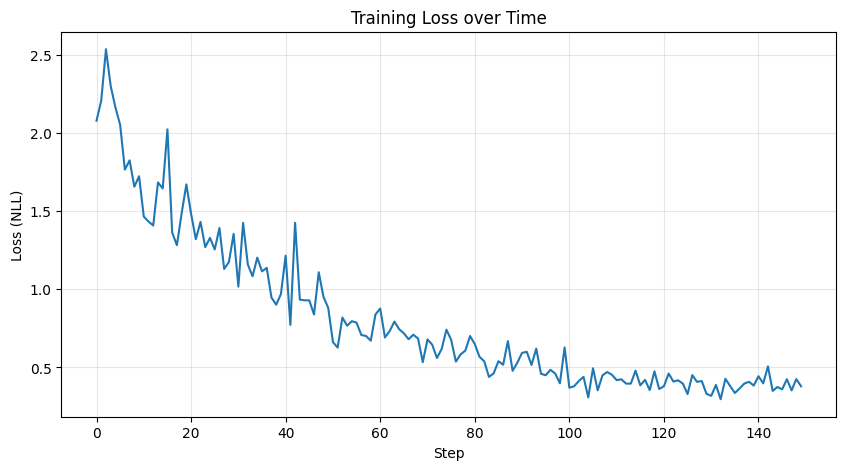

In [ ]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(training_losses)
plt.xlabel('Step')
plt.ylabel('Loss (NLL)')
plt.title('Training Loss over Time')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
sampling_client = training_client.save_weights_and_get_sampling_client(
    name="song-recommender-llm"
)

## 8. LLM-Based Recommendations

In [ ]:
def generate_llm_recommendations(query_idx, df, sampling_client, renderer, n_recommendations=5):
    """Generate recommendations using the fine-tuned LLM."""
    query_row = df.iloc[query_idx]
    query_title = query_row['title']
    query_artist = query_row['artist']
    query_lyrics = query_row['clean_lyrics'][:1000]

    prompt = f"""Recommend {n_recommendations} songs that are thematically and stylistically similar to the following song.

Title: {query_title}
Artist: {query_artist}
Lyrics:
{query_lyrics}

Please provide your recommendations in this format:
1. Song Title — Artist Name
2. Song Title — Artist Name
..."""

    # Create conversation
    messages = [{"role": "user", "content": prompt}]

    # Use conversation_to_datum
    from tinker_cookbook.supervised.data import conversation_to_datum
    from tinker_cookbook.tokenizer_utils import get_tokenizer

    datum = conversation_to_datum(
        messages,
        renderer,
        max_length=4096,
        train_on_what=renderers.TrainOnWhat.ALL_ASSISTANT_MESSAGES
    )

    # Create SamplingParams - reduce max_tokens to stop repetition
    sampling_params = tinker.SamplingParams(
        temperature=0.7,
        top_p=0.9,
        max_tokens=200  # Reduced from 500
    )

    # Sample
    try:
        future = sampling_client.sample(
            datum.model_input,
            1,
            sampling_params
        )
        result = future.result()

        # Decode tokens
        tokens = result.sequences[0].tokens
        tokenizer = get_tokenizer(MODEL_NAME)
        generated_text = tokenizer.decode(tokens)

        # Extract only the assistant's response (after "Assistant:" marker)
        # The renderer uses "User:" and "Assistant:" markers
        if "Assistant:" in generated_text:
            generated_text = generated_text.split("Assistant:")[-1].strip()

        # Remove any trailing "User:" if present (model might start generating next turn)
        if "User:" in generated_text:
            generated_text = generated_text.split("User:")[0].strip()

        # Take only the first 5 recommendations
        lines = [l.strip() for l in generated_text.split('\n') if l.strip()]
        # Filter to only lines that start with numbers (recommendations)
        recommendations = [l for l in lines if l and l[0].isdigit()][:n_recommendations]

        return '\n'.join(recommendations)

    except Exception as e:
        print(f"Sampling error: {e}")
        import traceback
        traceback.print_exc()
        return ""


def parse_llm_recommendations(generated_text, df, k=10):
    """Parse LLM output with robust error handling."""
    import re
    from difflib import SequenceMatcher

    def normalize_text(text):
        text = str(text).lower()
        text = re.sub(r'[^a-z0-9\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    # ⭐ NEW: Handle empty/None input
    if not generated_text or len(generated_text.strip()) == 0:
        return []

    # Extract song recommendations from text
    lines = generated_text.strip().split('\n')
    recommendations = []

    # ⭐ NEW: Multiple regex patterns to be more flexible
    patterns = [
        r'^\d+[\.\)]\s*["\']?([^"\'—\-]+)["\']?\s*[—]\s*([^"\']+)',  # 1. Title — Artist
        r'^\d+[\.\)]\s*["\']?([^"\'—\-]+)["\']?\s*[-]\s*([^"\']+)',  # 1. Title - Artist
        r'["\']?([^"\']+)["\']?\s+by\s+([^"\']+)',                    # Title by Artist
        r'^\d+[\.\)]\s*([^—\-]+)\s*[—-]\s*(.+)',                     # Flexible dash
    ]

    for line in lines:
        line = line.strip()
        if not line:
            continue

        # Try each pattern
        matched = False
        for pattern in patterns:
            match = re.search(pattern, line, re.IGNORECASE)
            if match:
                title = match.group(1).strip().strip('"').strip("'")
                artist = match.group(2).strip().strip('"').strip("'")
                if title and artist:
                    recommendations.append((title, artist))
                    matched = True
                    break

    # ⭐ NEW: Early return if no recommendations found
    if len(recommendations) == 0:
        return []

    # Match to dataset
    matched_indices = []

    for title, artist in recommendations[:k * 2]:  # Check more than k for better matches
        norm_title = normalize_text(title)
        norm_artist = normalize_text(artist)

        if not norm_title or not norm_artist:
            continue

        best_score = 0
        best_idx = None

        for idx, row in df.iterrows():
            ds_title = normalize_text(row['title'])
            ds_artist = normalize_text(row['artist'])

            title_score = SequenceMatcher(None, norm_title, ds_title).ratio()
            artist_score = SequenceMatcher(None, norm_artist, ds_artist).ratio()
            combined = (title_score + artist_score) / 2

            # ⭐ NEW: Lower threshold to 0.55 (was 0.6)
            if combined > best_score and combined >= 0.55:
                best_score = combined
                best_idx = idx

        # ⭐ NEW: Avoid duplicates
        if best_idx is not None and best_idx not in matched_indices:
            matched_indices.append(best_idx)

            if len(matched_indices) >= k:
                break

    return matched_indices[:k]  # Return exactly k (or fewer if not enough matches)


In [ ]:
# Test the LLM recommender on a few examples
print("Testing LLM recommendations...\n")

test_queries = query_songs[:3]  # Test on first 3 queries

for query_idx in test_queries:
    print(f"\n{'='*80}")
    print(f"Query Song: {df_sample.iloc[query_idx]['title']} by {df_sample.iloc[query_idx]['artist']}")
    print(f"{'='*80}")

    # Generate recommendations
    generated = generate_llm_recommendations(query_idx, df_sample, sampling_client, renderer)
    print("\n🤖 LLM Output:")
    print(generated)

    # Parse and show matched songs
    rec_indices = parse_llm_recommendations(generated, df_sample)
    print(f"\n✅ Matched {len(rec_indices)} songs to dataset")

    # Show ground truth for comparison
    relevant = gt.get_relevant_songs(query_idx)
    print(f"\n📋 Ground truth: {len(relevant)} similar songs in playlists")

Testing LLM recommendations...


Query Song: they say it's wonderful by sarah vaughan

🤖 LLM Output:
1. if you ever change your mind — ella fitzgerald
2. all on me — bj the chicago kid
3. comes love — ella fitzgerald
4. teach me tonight — aretha franklin
5. i could write a book — jimmy raney

✅ Matched 5 songs to dataset

📋 Ground truth: 34 similar songs in playlists

Query Song: teach me tonight by aretha franklin

🤖 LLM Output:
1. i want to go home — fats domino
2. walking to new orleans — ferlin husky
3. my life throw it away if i want to — fats domino
4. my eyes only see you — john parr
5. walking to new orleans [live] — fats domino

✅ Matched 5 songs to dataset

📋 Ground truth: 47 similar songs in playlists

Query Song: do nothin' till you hear from me by anthony wilson

🤖 LLM Output:
1. teach me tonight — aretha franklin
2. i got it bad (and that ain't good) — helen humes
3. it's de-lovely — oscar peterson
4. cry me a river — ella fitzgerald
5. i could write a book — jimmy raney


## 9. Evaluate LLM Recommender

In [ ]:
def evaluate_llm_model(query_songs, gt, sampling_client, renderer, df, k_values=[5, 10], model_name="LLM-SFT"):
    """Evaluate LLM with robust error handling."""
    results = []

    for k in k_values:
        metrics_sum = {'precision': 0, 'recall': 0, 'ndcg': 0, 'mrr': 0, 'hit': 0}
        successful_queries = 0
        failed_queries = []

        print(f"\nEvaluating {model_name} with K={k}...")
        print(f"Total queries: {len(query_songs)}")

        for query_idx in tqdm(query_songs, desc=f"{model_name} K={k}"):
            try:
                # Generate recommendations
                generated = generate_llm_recommendations(
                    query_idx, df, sampling_client, renderer, n_recommendations=k*2
                )

                # Check if generation succeeded
                if not generated or len(generated.strip()) == 0:
                    failed_queries.append((query_idx, "Empty LLM output"))
                    continue

                # Parse recommendations
                recommended_indices = parse_llm_recommendations(generated, df, k)

                # ⭐ NEW: Check if parsing returned empty list
                if len(recommended_indices) == 0:
                    failed_queries.append((query_idx, "Parsing returned no matches"))
                    continue

                # ⭐ NEW: Check if we got enough recommendations
                if len(recommended_indices) < k // 2:  # At least half of k
                    failed_queries.append((query_idx, f"Only got {len(recommended_indices)}/{k} recommendations"))
                    # Continue anyway with what we have

                # Get ground truth
                relevant = gt.get_relevant_songs(query_idx)

                if len(relevant) == 0:
                    failed_queries.append((query_idx, "No ground truth neighbors"))
                    continue

                # Calculate metrics
                metrics = compute_ranking_metrics(recommended_indices, relevant, k)

                for key in metrics_sum:
                    metrics_sum[key] += metrics[key]

                successful_queries += 1

            except IndexError as e:
                failed_queries.append((query_idx, f"IndexError: {str(e)}"))
                continue
            except Exception as e:
                failed_queries.append((query_idx, f"Error: {str(e)}"))
                continue

        # Calculate averages
        if successful_queries > 0:
            results.append({
                'Model': model_name,
                'K': k,
                'Precision@K': metrics_sum['precision'] / successful_queries,
                'Recall@K': metrics_sum['recall'] / successful_queries,
                'NDCG@K': metrics_sum['ndcg'] / successful_queries,
                'MRR@K': metrics_sum['mrr'] / successful_queries,
                'Hit@K': metrics_sum['hit'] / successful_queries,
                'Successful': successful_queries,
                'Failed': len(failed_queries),
                'Success_Rate': successful_queries / len(query_songs)
            })

            # Print summary
            print(f"\n{'='*60}")
            print(f"K={k} Summary:")
            print(f"  ✅ Successful: {successful_queries}/{len(query_songs)} ({successful_queries/len(query_songs)*100:.1f}%)")
            print(f"  ❌ Failed: {len(failed_queries)}")

            # Show failure breakdown
            if failed_queries:
                failure_types = {}
                for _, reason in failed_queries:
                    failure_types[reason] = failure_types.get(reason, 0) + 1

                print(f"\n  Failure breakdown:")
                for reason, count in sorted(failure_types.items(), key=lambda x: -x[1]):
                    print(f"    • {reason}: {count}")

            print(f"{'='*60}\n")

        else:
            print(f"⚠️  No successful queries for K={k}")
            results.append({
                'Model': model_name,
                'K': k,
                'Precision@K': 0,
                'Recall@K': 0,
                'NDCG@K': 0,
                'MRR@K': 0,
                'Hit@K': 0,
                'Successful': 0,
                'Failed': len(query_songs),
                'Success_Rate': 0
            })

    return results

In [ ]:
eval_queries = gt.get_query_songs()
print(f"\nEvaluating on {len(eval_queries)} query songs")
print(f"Average neighbors: {np.mean([len(gt.cooccurrence[q]) for q in eval_queries]):.1f}")
print("\nThis will take ~20-25 minutes...\n")

# Run evaluation
llm_results = evaluate_llm_model(
    eval_queries,
    gt,
    sampling_client,
    renderer,
    df_sample,        # ← Don't forget this!
    k_values=[5, 10],
    model_name="LLM-SFT"
)

# Display results
llm_results_df = pd.DataFrame(llm_results)
print("\n" + "="*80)
print("LLM RESULTS")
print("="*80)
print(llm_results_df.to_string(index=False))


Evaluating on 200 query songs
Average neighbors: 15.9

This will take ~20-25 minutes...


Evaluating LLM-SFT with K=5...
Total queries: 200


LLM-SFT K=5: 100%|██████████| 200/200 [24:30<00:00,  7.35s/it]



K=5 Summary:
  ✅ Successful: 171/200 (85.5%)
  ❌ Failed: 30

  Failure breakdown:
    • Empty LLM output: 26
    • IndexError: list index out of range: 2
    • Parsing returned no matches: 1
    • Only got 1/5 recommendations: 1


Evaluating LLM-SFT with K=10...
Total queries: 200


LLM-SFT K=10: 100%|██████████| 200/200 [46:47<00:00, 14.04s/it]


K=10 Summary:
  ✅ Successful: 137/200 (68.5%)
  ❌ Failed: 69

  Failure breakdown:
    • IndexError: list index out of range: 54
    • Empty LLM output: 8
    • Only got 4/10 recommendations: 4
    • Only got 3/10 recommendations: 2
    • Parsing returned no matches: 1


LLM RESULTS
  Model  K  Precision@K  Recall@K   NDCG@K    MRR@K    Hit@K  Successful  Failed  Success_Rate
LLM-SFT  5     0.438596  0.156123 0.447913 0.585965 0.748538         171      30         0.855
LLM-SFT 10     0.390511  0.266151 0.418458 0.565763 0.773723         137      69         0.685


## 10. Final Comparison

In [ ]:
# Combine all results
all_results_df = pd.concat([baseline_results_df, llm_results_df], ignore_index=True)

print("\n" + "="*80)
print("📊 FINAL RESULTS: All Models")
print("="*80)
print(all_results_df.to_string(index=False))

# Save results
all_results_df.to_csv('final_results.csv', index=False)
print("\n✅ Results saved to final_results.csv")


📊 FINAL RESULTS: All Models
   Model  K  Precision@K  Recall@K   NDCG@K    MRR@K    Hit@K  Successful  Failed  Success_Rate
  TF-IDF  5     0.006000  0.001803 0.004425 0.007667 0.030000         NaN     NaN           NaN
  TF-IDF 10     0.005000  0.003133 0.004305 0.010389 0.050000         NaN     NaN           NaN
Word2Vec  5     0.007000  0.002157 0.006844 0.015333 0.035000         NaN     NaN           NaN
Word2Vec 10     0.005000  0.003701 0.005670 0.017208 0.050000         NaN     NaN           NaN
   SBERT  5     0.013000  0.004432 0.013910 0.031833 0.060000         NaN     NaN           NaN
   SBERT 10     0.010000  0.006226 0.011782 0.035333 0.090000         NaN     NaN           NaN
 LLM-SFT  5     0.438596  0.156123 0.447913 0.585965 0.748538       171.0    30.0         0.855
 LLM-SFT 10     0.390511  0.266151 0.418458 0.565763 0.773723       137.0    69.0         0.685

✅ Results saved to final_results.csv


📊 FINAL COMPARISON: GENRE VS PLAYLIST EVALUATION

K = 5

1️⃣  GENRE-BASED EVALUATION (Traditional Approach)
--------------------------------------------------------------------------------
   Model  Precision@K  Recall@K   NDCG@K  Hit@K
  TF-IDF      0.18286  0.000915 0.383075 0.5544
Word2Vec      0.22034  0.001103 0.410930 0.5676
   SBERT      0.24506  0.001227 0.450104 0.6148

2️⃣  PLAYLIST-BASED EVALUATION (Realistic Approach)
--------------------------------------------------------------------------------
   Model  Precision@K  Recall@K   NDCG@K  Hit@K
  TF-IDF        0.006  0.001803 0.004425  0.030
Word2Vec        0.007  0.002157 0.006844  0.035
   SBERT        0.013  0.004432 0.013910  0.060

3️⃣  LLM RESULTS (Learning from Playlists)
--------------------------------------------------------------------------------
  Model  Precision@K  Recall@K   NDCG@K    Hit@K
LLM-SFT     0.438596  0.156123 0.447913 0.748538

K = 10

1️⃣  GENRE-BASED EVALUATION (Traditional Approach)
----------

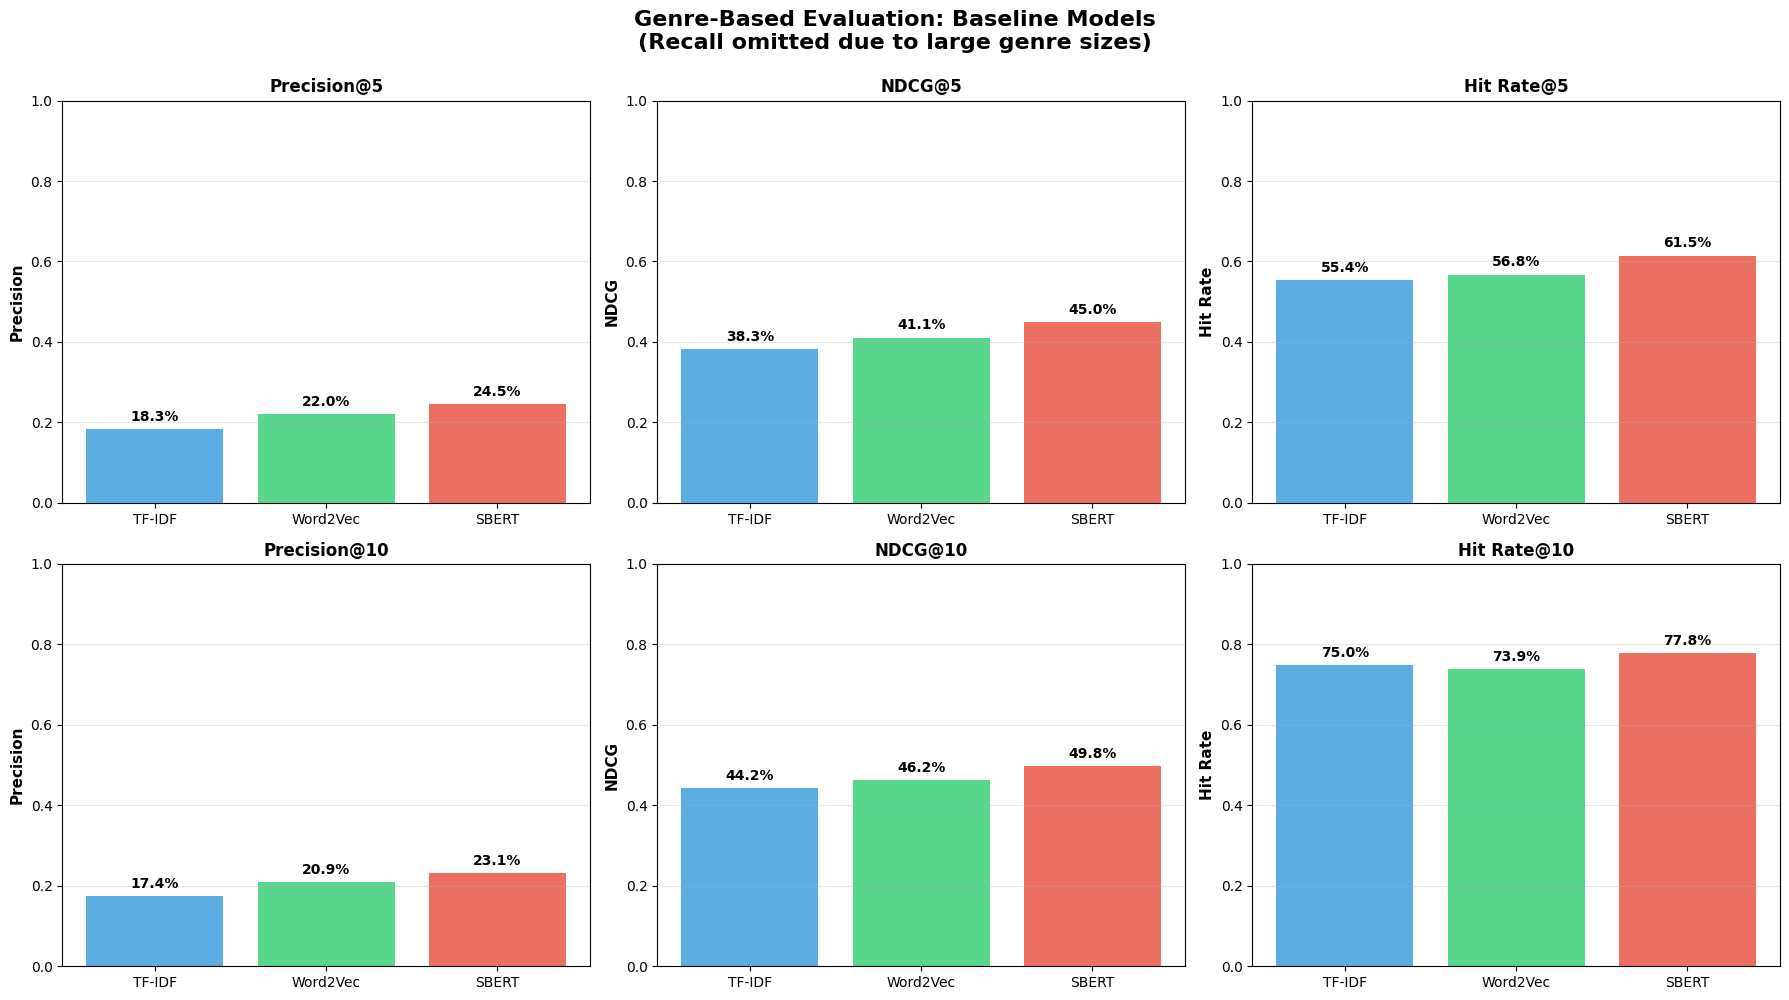

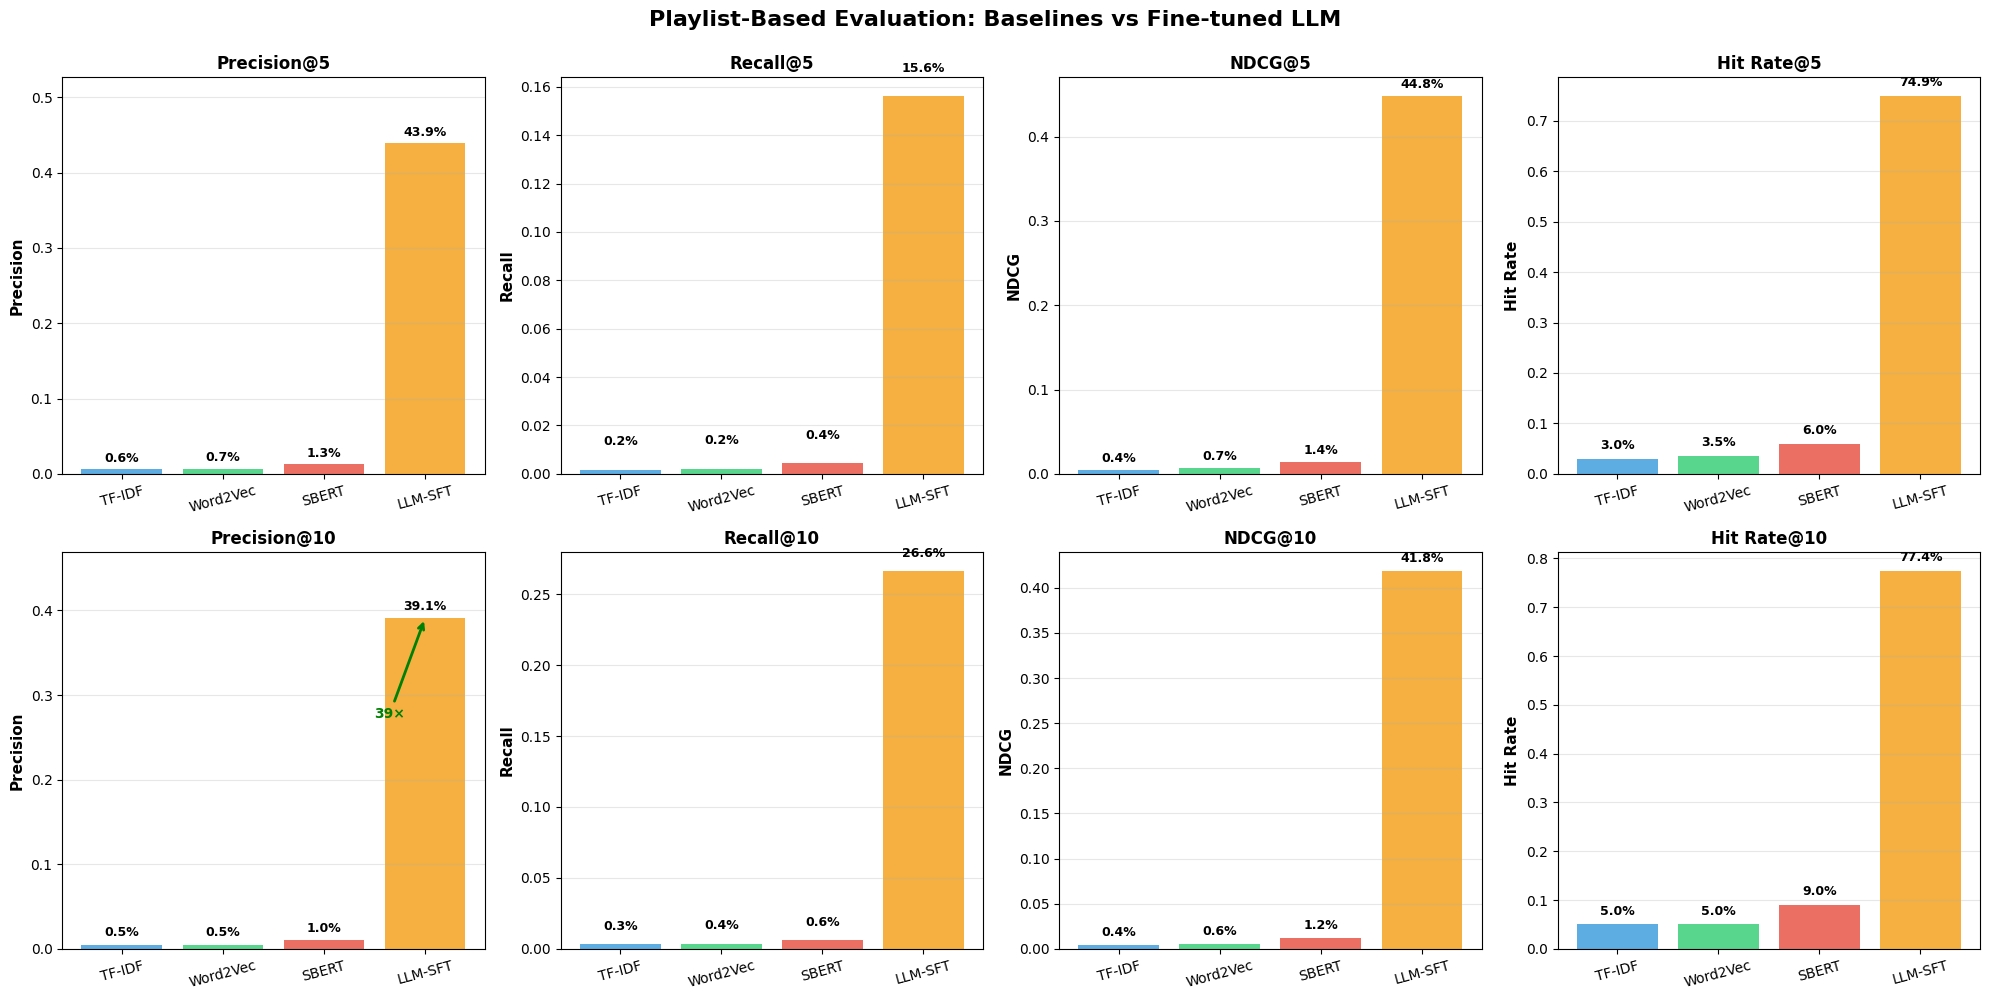

In [ ]:
# ============================================================================
# FINAL COMPARISON: GENRE vs PLAYLIST EVALUATION
# ============================================================================

print("="*80)
print("📊 FINAL COMPARISON: GENRE VS PLAYLIST EVALUATION")
print("="*80)

import matplotlib.pyplot as plt
import numpy as np

# Use your existing DataFrames
baseline_results = baseline_results_df

# Display results for both K values
for k_val in [5, 10]:
    print(f"\n{'='*80}")
    print(f"K = {k_val}")
    print(f"{'='*80}")

    print(f"\n1️⃣  GENRE-BASED EVALUATION (Traditional Approach)")
    print("-" * 80)
    genre_k = genre_results[genre_results['K'] == k_val]
    print(genre_k[['Model', 'Precision@K', 'Recall@K', 'NDCG@K', 'Hit@K']].to_string(index=False))

    print(f"\n2️⃣  PLAYLIST-BASED EVALUATION (Realistic Approach)")
    print("-" * 80)
    playlist_k = baseline_results[baseline_results['K'] == k_val]
    print(playlist_k[['Model', 'Precision@K', 'Recall@K', 'NDCG@K', 'Hit@K']].to_string(index=False))

    print(f"\n3️⃣  LLM RESULTS (Learning from Playlists)")
    print("-" * 80)
    llm_k = llm_results_df[llm_results_df['K'] == k_val]
    print(llm_k[['Model', 'Precision@K', 'Recall@K', 'NDCG@K', 'Hit@K']].to_string(index=False))

# ============================================================================
# GRAPH 1: GENRE-BASED EVALUATION (K=5 and K=10)
# ============================================================================
fig1, axes1 = plt.subplots(2, 3, figsize=(18, 10))

models = ['TF-IDF', 'Word2Vec', 'SBERT']
colors = ['#3498db', '#2ecc71', '#e74c3c']

for row, k_val in enumerate([5, 10]):
    genre_k = genre_results[genre_results['K'] == k_val]

    genre_precision = genre_k.set_index('Model')['Precision@K'].reindex(models).tolist()
    genre_ndcg = genre_k.set_index('Model')['NDCG@K'].reindex(models).tolist()
    genre_hit = genre_k.set_index('Model')['Hit@K'].reindex(models).tolist()

    # Plot 1: Precision
    ax1 = axes1[row, 0]
    bars1 = ax1.bar(models, genre_precision, color=colors, alpha=0.8)

    ax1.set_ylabel('Precision', fontweight='bold', fontsize=11)
    ax1.set_title(f'Precision@{k_val}', fontweight='bold', fontsize=12)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_ylim(0, 1.0)

    for i, val in enumerate(genre_precision):
        ax1.text(i, val + 0.02, f'{val:.1%}', ha='center', fontsize=10, fontweight='bold')

    # Plot 2: NDCG
    ax2 = axes1[row, 1]
    bars2 = ax2.bar(models, genre_ndcg, color=colors, alpha=0.8)

    ax2.set_ylabel('NDCG', fontweight='bold', fontsize=11)
    ax2.set_title(f'NDCG@{k_val}', fontweight='bold', fontsize=12)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_ylim(0, 1.0)

    for i, val in enumerate(genre_ndcg):
        ax2.text(i, val + 0.02, f'{val:.1%}', ha='center', fontsize=10, fontweight='bold')

    # Plot 3: Hit Rate
    ax3 = axes1[row, 2]
    bars3 = ax3.bar(models, genre_hit, color=colors, alpha=0.8)

    ax3.set_ylabel('Hit Rate', fontweight='bold', fontsize=11)
    ax3.set_title(f'Hit Rate@{k_val}', fontweight='bold', fontsize=12)
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.set_ylim(0, 1.0)

    for i, val in enumerate(genre_hit):
        ax3.text(i, val + 0.02, f'{val:.1%}', ha='center', fontsize=10, fontweight='bold')

plt.suptitle('Genre-Based Evaluation: Baseline Models\n(Recall omitted due to large genre sizes)',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('genre_based_evaluation_k5_k10.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# GRAPH 2: PLAYLIST-BASED EVALUATION (K=5 and K=10)
# ============================================================================

fig2, axes2 = plt.subplots(2, 4, figsize=(20, 10))

models_with_llm = ['TF-IDF', 'Word2Vec', 'SBERT', 'LLM-SFT']
colors_with_llm = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

for row, k_val in enumerate([5, 10]):
    playlist_k = baseline_results[baseline_results['K'] == k_val]
    llm_k = llm_results_df[llm_results_df['K'] == k_val]

    # Get playlist values
    playlist_precision = playlist_k.set_index('Model')['Precision@K'].reindex(['TF-IDF', 'Word2Vec', 'SBERT']).tolist()
    playlist_recall = playlist_k.set_index('Model')['Recall@K'].reindex(['TF-IDF', 'Word2Vec', 'SBERT']).tolist()
    playlist_ndcg = playlist_k.set_index('Model')['NDCG@K'].reindex(['TF-IDF', 'Word2Vec', 'SBERT']).tolist()
    playlist_hit = playlist_k.set_index('Model')['Hit@K'].reindex(['TF-IDF', 'Word2Vec', 'SBERT']).tolist()

    # Add LLM results
    playlist_precision.append(llm_k['Precision@K'].values[0])
    playlist_recall.append(llm_k['Recall@K'].values[0])
    playlist_ndcg.append(llm_k['NDCG@K'].values[0])
    playlist_hit.append(llm_k['Hit@K'].values[0])

    # Plot 1: Precision
    ax1 = axes2[row, 0]
    bars1 = ax1.bar(models_with_llm, playlist_precision, color=colors_with_llm, alpha=0.8)

    ax1.set_ylabel('Precision', fontweight='bold', fontsize=11)
    ax1.set_title(f'Precision@{k_val}', fontweight='bold', fontsize=12)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_ylim(0, max(playlist_precision) * 1.2)
    ax1.tick_params(axis='x', rotation=15)

    for i, val in enumerate(playlist_precision):
        ax1.text(i, val + 0.01, f'{val:.1%}', ha='center', fontsize=9, fontweight='bold')

    # Add improvement annotation for K=10
    if k_val == 10:
        llm_improvement = playlist_precision[3] / playlist_precision[2]
        ax1.annotate(f'{llm_improvement:.0f}×',
                     xy=(3, playlist_precision[3]),
                     xytext=(2.5, playlist_precision[3] * 0.7),
                     arrowprops=dict(arrowstyle='->', color='green', lw=2),
                     fontsize=10, color='green', fontweight='bold')

    # Plot 2: Recall
    ax2 = axes2[row, 1]
    bars2 = ax2.bar(models_with_llm, playlist_recall, color=colors_with_llm, alpha=0.8)

    ax2.set_ylabel('Recall', fontweight='bold', fontsize=11)
    ax2.set_title(f'Recall@{k_val}', fontweight='bold', fontsize=12)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.tick_params(axis='x', rotation=15)

    for i, val in enumerate(playlist_recall):
        ax2.text(i, val + 0.01, f'{val:.1%}', ha='center', fontsize=9, fontweight='bold')

    # Plot 3: NDCG
    ax3 = axes2[row, 2]
    bars3 = ax3.bar(models_with_llm, playlist_ndcg, color=colors_with_llm, alpha=0.8)

    ax3.set_ylabel('NDCG', fontweight='bold', fontsize=11)
    ax3.set_title(f'NDCG@{k_val}', fontweight='bold', fontsize=12)
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.tick_params(axis='x', rotation=15)

    for i, val in enumerate(playlist_ndcg):
        ax3.text(i, val + 0.01, f'{val:.1%}', ha='center', fontsize=9, fontweight='bold')

    # Plot 4: Hit Rate
    ax4 = axes2[row, 3]
    bars4 = ax4.bar(models_with_llm, playlist_hit, color=colors_with_llm, alpha=0.8)

    ax4.set_ylabel('Hit Rate', fontweight='bold', fontsize=11)
    ax4.set_title(f'Hit Rate@{k_val}', fontweight='bold', fontsize=12)
    ax4.grid(True, alpha=0.3, axis='y')
    ax4.tick_params(axis='x', rotation=15)

    for i, val in enumerate(playlist_hit):
        ax4.text(i, val + 0.02, f'{val:.1%}', ha='center', fontsize=9, fontweight='bold')

plt.suptitle('Playlist-Based Evaluation: Baselines vs Fine-tuned LLM',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('playlist_based_comparison_k5_k10.png', dpi=300, bbox_inches='tight')
plt.show()